In [1]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import numpy as np
from sklearn.metrics import*
import keras.activations
from keras.callbacks import EarlyStopping
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
epsilon= 0.000001
learning_rate=0.001
num_epochs=55
validation_ratio=0.3
num_test=45

In [3]:
root="../input/mid-brain-images/data"
print(os.listdir(root))

['data']


In [4]:
x_ee = np.load('../input/data-pca/x_abnormal.npy')
s_ee = np.load("../input/data-pca/s_abnormal.npy")
xx = np.load('../input/data-pca/x_normal.npy')
ss = np.load('../input/data-pca/s_normal.npy')
x_test = np.concatenate((x_ee, xx))
s_test = np.concatenate((s_ee, ss))

In [5]:
x_test = np.expand_dims(x_test, axis=3)
s_test = np.expand_dims(s_test, axis=1)

In [6]:
root="../input/mid-brain-images/data/data/"
x=[]
s=[]
for i in range(1, 7):
    x_temp = np.load(root+'x_train'+str(i)+'.npy')
    s_temp = np.load(root+'s_train'+str(i)+'.npy')
    x.append(x_temp); s.append(s_temp)

In [7]:
for i in range(1, 6):
    x[0]= np.concatenate((x[0], x[i]))
for i in range(1, 6):
    s[0]= np.concatenate((s[0], s[i]))

In [8]:
x_test, s_test = shuffle(x_test, s_test)

In [9]:
x_val, s_val = x_test[0:num_test, :, :, :], s_test[0:num_test,:]

In [10]:
x[0] = np.expand_dims(x[0], axis=3)
s[0] = np.expand_dims(s[0], axis=1)
x[0]= np.concatenate((x[0], x_val))
s[0]= np.concatenate((s[0], s_val))

In [11]:
x_train,s_train= shuffle(x[0], s[0])

In [12]:
mean= np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train-mean)/(std+epsilon)
# x_train = np.expand_dims(x_train, axis=3)
# s_train= np.expand_dims(s_train, axis=1)

In [13]:
x_test = (x_test-mean)/(std+epsilon)

In [14]:
def convautoencoder(input_shape):
    X_input=Input(input_shape)
    out = Conv2D(16,(3,3),strides=(2,2),activation='relu')(X_input)  #87,87,16
    out = MaxPool2D(strides=(1,1))(out)#86,86,16
    out = Conv2D(8, (3, 3), strides=(2,2),activation='relu')(out) #42,42,8
    out = MaxPooling2D(strides=(1, 1))(out)  #41,41,8
    out = Conv2D(8, (3, 3),strides=(2,2),activation='relu')(out)  #20,20,8
    encoded = MaxPooling2D(strides=(1, 1))(out)  #19,19,8

    out = Conv2D(8, (3, 3),strides=(2,2),activation='relu')(encoded)  #9,9,8
    out = UpSampling2D((7, 7))(out)  
    out= Conv2D(8, (3, 3), activation='relu',strides=(2,2))(out) 
    out = UpSampling2D((4, 4))(out)  
    out = Conv2D(16, (3, 3), activation='relu',strides=(2,2))(out)
    out = UpSampling2D((6, 6))(out)
    decoded = Conv2D(1, (7, 7), activation='sigmoid',strides=(2,2))(out)    
    print(decoded.shape)
    return Model(inputs=X_input,outputs=decoded)

In [15]:
autoencoder=convautoencoder((180,180,1))
autoencoder.compile(optimizer='adadelta',loss='binary_crossentropy')

(?, 180, 180, 1)


In [16]:
history=autoencoder.fit(x=x_train,y=x_train,epochs=20,batch_size=128,validation_data=(x_test,x_test))

Train on 16479 samples, validate on 942 samples
Epoch 1/20
16479/16479 [==============================] - 92s 6ms/step - loss: -2.7466 - val_loss: -43.1893
Epoch 2/20
16479/16479 [==============================] - 85s 5ms/step - loss: -3.4973 - val_loss: -59.1354
Epoch 3/20
16479/16479 [==============================] - 82s 5ms/step - loss: -3.6235 - val_loss: -63.4082
Epoch 4/20
16479/16479 [==============================] - 84s 5ms/step - loss: -3.6799 - val_loss: -64.5192
Epoch 5/20
16479/16479 [==============================] - 82s 5ms/step - loss: -3.7372 - val_loss: -58.4128
Epoch 6/20
16479/16479 [==============================] - 84s 5ms/step - loss: -3.7497 - val_loss: -65.0131
Epoch 7/20
16479/16479 [==============================] - 83s 5ms/step - loss: -3.7741 - val_loss: -62.1947
Epoch 8/20
16479/16479 [==============================] - 82s 5ms/step - loss: -3.7823 - val_loss: -56.6514
Epoch 9/20
16479/16479 [==============================] - 82s 5ms/step - loss: -3.7931 -

In [21]:
pred = autoencoder.predict(x_test)

Test Images


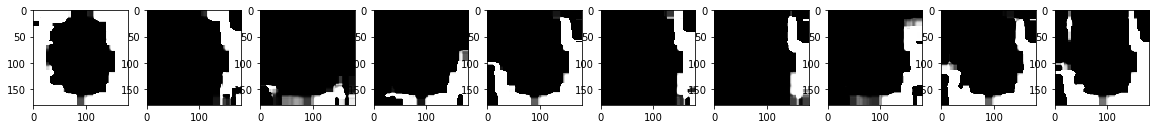

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')
plt.show() 

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

TypeError: 'History' object is not subscriptable

In [18]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180, 180, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 89, 89, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 88, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 42, 42, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 8)         0         
__________

In [59]:
def encodermodel(input_shape):
    input_img = Input(input_shape)
    out = autoencoder.layers[1](input_img)
    out =  autoencoder.layers[2](out)
    out = autoencoder.layers[3](out)
    out =  autoencoder.layers[4](out)
    out = autoencoder.layers[5](out)
    out =  autoencoder.layers[6](out)
    
    return Model(input_img,out)
   
    

In [60]:
encoder=encodermodel((180,180,1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 180, 180, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 89, 89, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 88, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 42, 42, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 8)         0         
Total para

In [63]:
pred2=encoder.predict(x_test)

Test Images


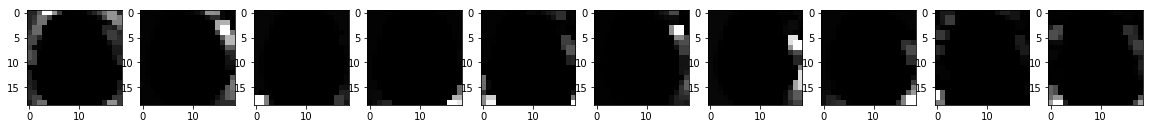

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred2[i, ..., 0], cmap='gray')
plt.show() 

In [71]:
def completemodel(input_shape):
    
    input_img = Input(input_shape)
    out = autoencoder.layers[1](input_img)
    out =  autoencoder.layers[2](out)
    out = autoencoder.layers[3](out)
    out =  autoencoder.layers[4](out)
    out = autoencoder.layers[5](out)
    out =  autoencoder.layers[6](out)
    # Encoder part till here 
    
    out= Activation('relu')(out) 
    out= Conv2D(32, (5, 5), activation='relu', strides=(2, 2))(out) #7, 7, 64
    out= Flatten()(out)
    out= Dense(512, activation='relu')(out)
    out= BatchNormalization()(out)
    out= Dense(64, activation='relu')(out)
    out= BatchNormalization()(out)
    out= Dense(10, activation='relu')(out)
    out= Dense(1, activation='sigmoid')(out)
    
    return Model(inputs= input_img, outputs= out)

In [72]:
model2=completemodel((180,180,1))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 180, 180, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 89, 89, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 88, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 42, 42, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 8)         0         
__________

In [76]:
for layer in model2.layers[:7]: #make first 7 layers untrainable i.e., fixed weights
    layer.trainable=False

In [77]:
model2.compile(optimizer='Nadam',loss='binary_crossentropy',metrics=['accuracy'])

In [78]:
history2=model2.fit(x=x_train,y=s_train, batch_size=64,epochs=55,verbose=True, validation_data=(x_test, s_test))
model2.save('saved_model2.h5')

Train on 16479 samples, validate on 942 samples
Epoch 1/55
16479/16479 [==============================] - 10s 591us/step - loss: 0.4017 - acc: 0.8174 - val_loss: 1.6796 - val_acc: 0.5637
Epoch 2/55
16479/16479 [==============================] - 7s 453us/step - loss: 0.2992 - acc: 0.8626 - val_loss: 1.7323 - val_acc: 0.6253
Epoch 3/55
16479/16479 [==============================] - 8s 461us/step - loss: 0.2470 - acc: 0.8874 - val_loss: 2.2360 - val_acc: 0.5297
Epoch 4/55
16479/16479 [==============================] - 7s 455us/step - loss: 0.2095 - acc: 0.9065 - val_loss: 1.9289 - val_acc: 0.6051
Epoch 5/55
16479/16479 [==============================] - 8s 460us/step - loss: 0.1828 - acc: 0.9201 - val_loss: 1.3085 - val_acc: 0.6507
Epoch 6/55
16479/16479 [==============================] - 7s 450us/step - loss: 0.1591 - acc: 0.9314 - val_loss: 1.9221 - val_acc: 0.5870
Epoch 7/55
16479/16479 [==============================] - 8s 459us/step - loss: 0.1471 - acc: 0.9365 - val_loss: 1.7988 - v

In [79]:
predictions =model2.predict(x_test)
predictions= predictions>=0.5
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_curve
accuracy_score = accuracy_score(s_test, predictions)
recall_score= recall_score(s_test, predictions)
f1_score=f1_score(s_test, predictions)
from scipy.spatial.distance import dice
dice_diss_coeff = dice(s_test, predictions)
DSC= 1-dice_diss_coeff
print('num_test ='+str(num_test))
print("DSC = "+str(DSC))
print("accuracy = "+str(accuracy_score))
print('recall = '+str(recall_score))
print('f1 score = '+str(f1_score))

num_test =45
DSC = 0.7377584330794342
accuracy = 0.7441613588110403
recall = 0.8228155339805825
f1 score = 0.7377584330794342


In [80]:
predictions = model2.predict(x_val)
predictions = predictions>0.5
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_curve, precision_score
precision_score= precision_score(s_val, predictions)
accuracy_score = accuracy_score(s_val, predictions)
recall_score= recall_score(s_val, predictions)
f1_score=f1_score(s_val, predictions)
from scipy.spatial.distance import dice
dice_diss_coeff = dice(s_val, predictions)
DSC= 1-dice_diss_coeff
print("DSC = "+str(DSC))
print("accuracy = "+str(accuracy_score))
print('recall = '+str(recall_score))
print('f1 score = '+str(f1_score))
print('precision score = '+str(precision_score))

DSC = 0.46153846153846156
accuracy = 0.5333333333333333
recall = 0.6
f1 score = 0.4615384615384615
precision score = 0.375


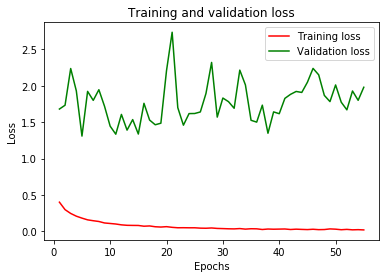

In [81]:
import matplotlib.pyplot as plt
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

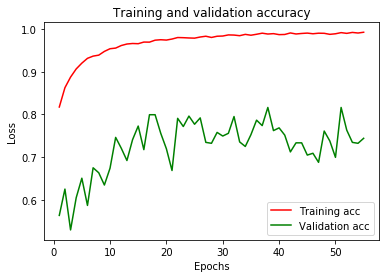

In [82]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [85]:
#applying batch norm
def CNN2_model(input_shape):
    X_input = Input(input_shape)  # 180, 180, 1
    out= Conv2D(4, (9, 9),strides= (2, 2))(X_input) #86,86,4
    out= MaxPool2D(strides=(1, 1))(out) #85,85,4
    out= Activation('relu')(out) #85, 85, 4
    out= Conv2D(16, (7, 7),strides=  (2, 2))(out) #40, 40, 16
    out= MaxPool2D(strides=(1, 1))(out) #39, 39, 16
    out= Activation('relu')(out) 
    out= Conv2D(32, (5, 5), strides= (2, 2))(out) #18,18 32
    out= MaxPool2D(strides=(1, 1))(out) #17, 17, 32
    out= Activation('relu')(out) 
    out= Conv2D(64, (5, 5), activation='relu', strides=(2, 2))(out) #7, 7, 64
    out= Flatten()(out)
    out= Dense(2048, activation='relu')(out)
    out= BatchNormalization()(out)
    out= Dense(1024, activation='relu')(out)
    out= BatchNormalization()(out)
    out= Dense(512, activation='relu')(out)
    out= BatchNormalization()(out)
    out= Dense(64, activation='relu')(out)
    out= BatchNormalization()(out)
    out= Dense(10, activation='relu')(out)
    out= Dense(1, activation='sigmoid')(out)
    
    return Model(inputs= X_input, outputs= out)

In [ ]:
pred1=autoencoder.predict(x_train)
print(x_train.shape)
print(pred1.shape)

In [86]:

es = EarlyStopping(monitor='val_loss', mode='min', patience=10,baseline=0.974, verbose=True)
model3= CNN2_model((180, 180, 1))
model3.compile(optimizer='Nadam',loss='binary_crossentropy',metrics=['accuracy'])
history=model3.fit(x=x_train,y=s_train, batch_size=64,epochs=55,verbose=True, validation_data=(x_test, s_test))
model3.save('saved_model3.h5')
predictions =model3.predict(x_test)
predictions= predictions>=0.5
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_curve
accuracy_score = accuracy_score(s_test, predictions)
recall_score= recall_score(s_test, predictions)
f1_score=f1_score(s_test, predictions)
from scipy.spatial.distance import dice
dice_diss_coeff = dice(s_test, predictions)
DSC= 1-dice_diss_coeff
print('num_test ='+str(num_test))
print("DSC = "+str(DSC))
print("accuracy = "+str(accuracy_score))
print('recall = '+str(recall_score))
print('f1 score = '+str(f1_score))

Train on 16479 samples, validate on 942 samples
Epoch 1/55
16479/16479 [==============================] - 17s 1ms/step - loss: 0.4414 - acc: 0.8064 - val_loss: 1.5529 - val_acc: 0.4321
Epoch 2/55
16479/16479 [==============================] - 15s 887us/step - loss: 0.3807 - acc: 0.8192 - val_loss: 2.2775 - val_acc: 0.5648
Epoch 3/55
16479/16479 [==============================] - 15s 888us/step - loss: 0.3460 - acc: 0.8383 - val_loss: 1.6261 - val_acc: 0.5584
Epoch 4/55
16479/16479 [==============================] - 15s 884us/step - loss: 0.2948 - acc: 0.8640 - val_loss: 1.6826 - val_acc: 0.5488
Epoch 5/55
16479/16479 [==============================] - 15s 886us/step - loss: 0.2513 - acc: 0.8903 - val_loss: 1.5832 - val_acc: 0.6072
Epoch 6/55
16479/16479 [==============================] - 15s 891us/step - loss: 0.2114 - acc: 0.9090 - val_loss: 1.8654 - val_acc: 0.6242
Epoch 7/55
16479/16479 [==============================] - 15s 896us/step - loss: 0.1743 - acc: 0.9278 - val_loss: 1.8621

In [87]:
predictions = model3.predict(x_val)
predictions = predictions>0.5
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_curve, precision_score
precision_score= precision_score(s_val, predictions)
accuracy_score = accuracy_score(s_val, predictions)
recall_score= recall_score(s_val, predictions)
f1_score=f1_score(s_val, predictions)
from scipy.spatial.distance import dice
dice_diss_coeff = dice(s_val, predictions)
DSC= 1-dice_diss_coeff
print("DSC = "+str(DSC))
print("accuracy = "+str(accuracy_score))
print('recall = '+str(recall_score))
print('f1 score = '+str(f1_score))
print('precision score = '+str(precision_score))

DSC = 0.5555555555555556
accuracy = 0.4666666666666667
recall = 1.0
f1 score = 0.5555555555555556
precision score = 0.38461538461538464


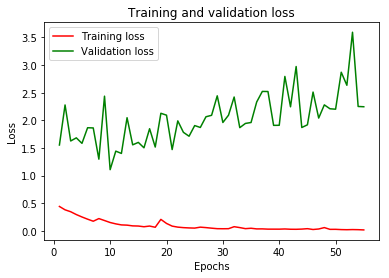

In [88]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

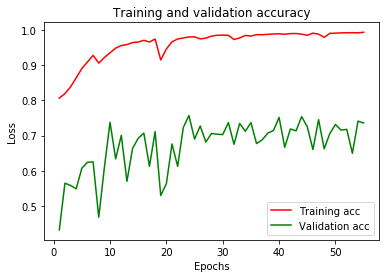

In [89]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()